In [178]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../vision_analyze'))  # insert parent path
import time
import numpy as np
from tqdm import tqdm
from copy import deepcopy
# from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


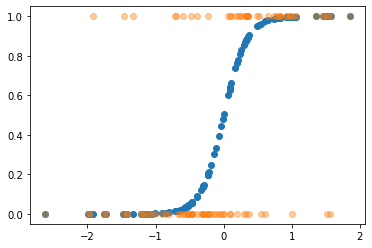

In [174]:
n = 100
p = 1
w = 6
eps = 0.3

np.random.seed(42)
X = np.random.randn(n, p)
sig = 1 / (1 + np.exp(-w * X))
y = (np.random.rand(n, 1) + np.random.randn(n, 1) * eps < sig).astype(int) # bernoulli with sig as p
y_onehot = np.zeros((n, 2))
y_onehot[np.arange(n), y.flatten()] = 1
plt.plot(X, sig, 'o')
plt.plot(X, y, 'o', alpha=0.4)
plt.show()

In [175]:
from torch.optim import SGD
from torch import nn
import torch

class MLPClassifier(nn.Module):
    '''Pytorch MLP Classifier
    '''
    def __init__(self, input_dim, criterion=nn.CrossEntropyLoss()):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 2)
        self.softmax = nn.Softmax(dim=1)
        self.criterion = criterion
        

    def forward(self, x: torch.Tensor):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x
    
    
    # sklearn-style methods
    def predict_proba(self, X: np.ndarray):
        X = torch.Tensor(X)
        return self.forward(X).cpu().detach().numpy()
    
    def predict(self, X: np.ndarray):
        return (self.predict_proba(X)  > 0.5).astype(np.int)
    
    def fit(self, X: np.ndarray, y: np.ndarray, epochs=100, lr=1e-3):
        X = torch.Tensor(X)
        y = torch.Tensor(y)
        optimizer = SGD(self.parameters(), lr=lr)
        running_loss = 0.0
        for i in tqdm(range(epochs)):
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            preds = self.forward(X)
            loss = self.criterion(preds, y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % epochs // 3 == 0:    # print every 2000 mini-batches
                print(f'{i} {running_loss:0.2f}\t', end='')
                running_loss = 0.0

In [176]:
def BinaryCrossEntropyGeneric(preds, targets):
    '''Implements −mean(y log(p) + (1−y)log(1−p))
    '''
    return -1 * (targets[:, 1] * torch.log(preds[:, 1]) + targets[:, 0] * torch.log(preds[:, 0])).mean()

def CrossEntropyGeneric(preds, targets):
    '''Implements -mean(y_i log pred_i)
    Not correct!
    '''
    return -1 * (targets * torch.log(preds)).mean()

lr = 1e-1
m1 = MLPClassifier(input_dim=X.shape[1], criterion=BinaryCrossEntropyGeneric)
m1.fit(X, y_onehot, epochs=1000, lr=lr)
preds = m1.predict_proba(X)


ms = []
ys = []
ms.append(m1)
ys.append(preds)
for i in range(3):
    m = MLPClassifier(input_dim=X.shape[1], criterion=BinaryCrossEntropyGeneric)
    m.fit(X, preds, epochs=1000, lr=lr)
    preds = m.predict_proba(X)
    ms.append(deepcopy(m))
    ys.append(deepcopy(preds))

 16%|█▌        | 162/1000 [00:00<00:01, 795.32it/s]

0 0.82	1 0.65	2 0.59	

 12%|█▏        | 124/1000 [00:00<00:01, 623.30it/s]

0 0.84	1 0.68	2 0.61	

 16%|█▌        | 160/1000 [00:00<00:01, 782.58it/s]

0 0.71	1 0.59	2 0.56	

 15%|█▌        | 153/1000 [00:00<00:01, 758.85it/s]

0 0.69	1 0.62	2 0.58	

100%|██████████| 1000/1000 [00:01<00:00, 787.66it/s]


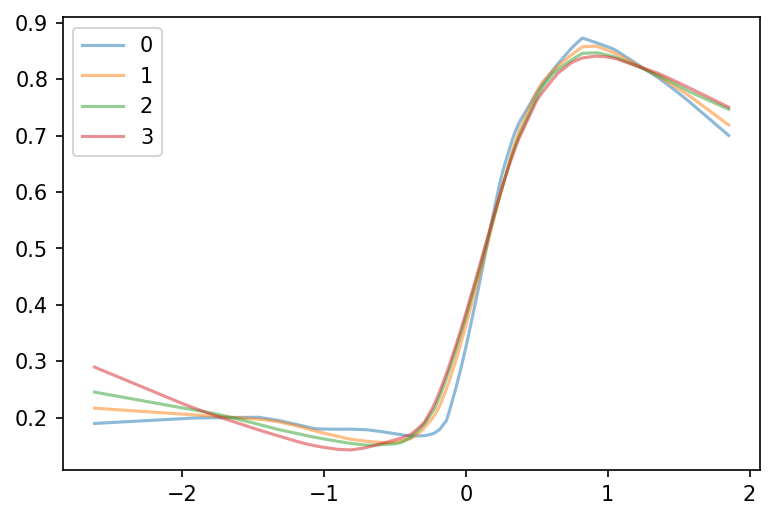

In [177]:
plt.figure(dpi=150)
args = np.argsort(X.flatten()).flatten()
for i in range(len(ys)):
    plt.plot(X[args], ys[i][args, 1], '-', label=i, alpha=0.5, markeredgewidth=0)
plt.legend()
plt.show()